# NLP Document Locator

## Import statements

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

import pandas as pd
import numpy as np
import random

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [2]:
import json
with open('/home/jupyter/nlp_document_finder/data/train2.json') as file:
    data = json.load(file)

## Preprocessing

In [3]:
# words = []
# labels = []
# docs_x = []
# docs_y = []

# # ------------------- TOKENIZE ----------------- #
# for intent in data['intents']:
#     for pattern in intent['patterns']:
#         wrds = nltk.word_tokenize(pattern)
#         words.extend(wrds)
#         docs_x.append(wrds)
#         docs_y.append(intent["tag"])
        
#     if intent['tag'] not in labels:
#         labels.append(intent['tag'])
       

In [4]:
# # --------------------STOP WORD REMOVAL ----------#
# from nltk.corpus import stopwords
# stop_words = list(set(stopwords.words('english'))) 

# for word in words:
#     if word in stop_words:
#         words.remove(word)

# for wrd in docs_x:
#     for word in wrd:
#         if word in stop_words:
#             wrd.remove(word)

In [5]:
# # ------------------ REMOVE PUNCTUATION ----------- #
# import string
# for word in words:
#     word = word.translate(str.maketrans('', '', string.punctuation))
#     word = word.strip()


# for wrd in docs_x:
#     for word in wrd:
#         word = word.translate(str.maketrans('', '', string.punctuation))
#         word = word.strip()

In [6]:
# # ---------------- STEMMING ------------------ #
# words = [stemmer.stem(w.lower()) for w in words if w != "?"]
# words = sorted(list(set(words)))

# labels = sorted(labels)

In [7]:
rows = []
labels = []
for intent in data['intents']:
    rows.extend(intent['train_data'])
    label = []
    label.append(intent['label'])
    labels.extend(label*len(intent['train_data']))

### Date Recognition

In [8]:
from datetime import datetime

def decode_date(tokens):

    months_fullform = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'decemeber']
    months_shortform = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    month = 0
    for token in tokens:
        try:
            int(token)
        except:
            if token.lower() in months_fullform:
                month = months_fullform.index(token.lower()) + 1
            elif token.lower() in months_shortform:
                month = months_shortform.index(token.lower()) + 1
            tokens.remove(token)
        
    if len(tokens) > 2:
        if month:
            day = int(tokens[0])
            year = int(tokens[2])
        else:
            day = int(tokens[0])
            month = int(tokens[1])
            year = int(tokens[2])
    elif len(tokens) > 1:
        if month:
            day = int(tokens[0])
            year = 2020
        else:
            day = int(tokens[0])
            month = int(tokens[1])
            year = 2020
    elif len(tokens)==1:
        day = int(tokens[0])
        year = 2020
    return (day, month, year)

In [9]:
# !python3 -m spacy download en_core_web_lg
import spacy
sp_lg = spacy.load('en_core_web_lg')
import nltk
import re

query_date = {}
for idx, row in enumerate(rows):
    date_occurences = [(ent.text.strip(), ent.label_) for ent in sp_lg(row).ents if ent.label_ == 'DATE']
    query_date[row] = []
    
    for date in date_occurences:
        try:
            date_token = re.split('\s+|/|-|:',date[0])
            day, month, year = decode_date(date_token)
            query_date[row].append((day, month, year))
            row = row.replace(date[0], "", 1)
            rows[idx] = row
        except:
            pass

### Universal Sentence Encoder

In [10]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [11]:
embedding = embed(rows)

X = pd.DataFrame(data=embedding.numpy())
X['label'] = labels

In [12]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,-0.023522,-0.027589,-0.015897,0.021743,0.027776,0.011346,0.018255,0.028732,0.064652,-0.080686,...,-0.007931,0.055987,-0.059289,0.028541,0.001592,0.027852,0.019604,-0.089315,-0.069819,marketing_kaggle
1,-0.002800,0.004039,-0.036565,0.020619,0.035993,0.022251,0.032340,0.029259,0.028480,-0.077354,...,-0.054188,0.007662,-0.061701,0.016212,0.016110,-0.020822,0.069056,-0.080873,-0.054029,marketing_kaggle
2,-0.002595,0.013395,-0.015542,0.005902,0.001254,-0.000004,0.021245,0.037117,0.044805,-0.054018,...,0.008258,0.023106,-0.071179,0.041438,0.027743,0.039953,0.066588,-0.090802,-0.061921,marketing_kaggle
3,-0.015161,0.060924,-0.015563,0.015570,-0.048320,0.004806,-0.049353,0.021348,0.012264,-0.068966,...,-0.057275,0.052424,-0.049835,0.037803,0.001642,0.005462,0.065089,-0.069093,-0.014209,marketing_kaggle
4,0.014937,-0.008112,-0.049251,0.030344,0.047071,0.008654,0.033338,0.037916,0.021403,-0.069347,...,0.030978,0.054777,-0.049153,0.032623,-0.000436,0.013973,0.050768,-0.090002,-0.052556,marketing_kaggle


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1)
    fig, ax = plt.subplots(figsize=(18, 18))
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd", 
      ax=ax)
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)


messages = rows

# run_and_plot(messages)
               

### t-SNE

In [14]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(X.drop(columns=['label']))
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 135 samples in 0.003s...
[t-SNE] Computed neighbors for 135 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 135 / 135
[t-SNE] Mean sigma: 0.366267
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.913551
[t-SNE] KL divergence after 300 iterations: 0.395781
t-SNE done! Time elapsed: 0.22373557090759277 seconds


In [15]:
tsne_results[0:9, 0]

array([ 3.211175 , -0.7962864,  3.1874082, -1.5294228,  1.0309548,
        5.2447157, -1.7644832,  3.2830586, -2.3120482], dtype=float32)

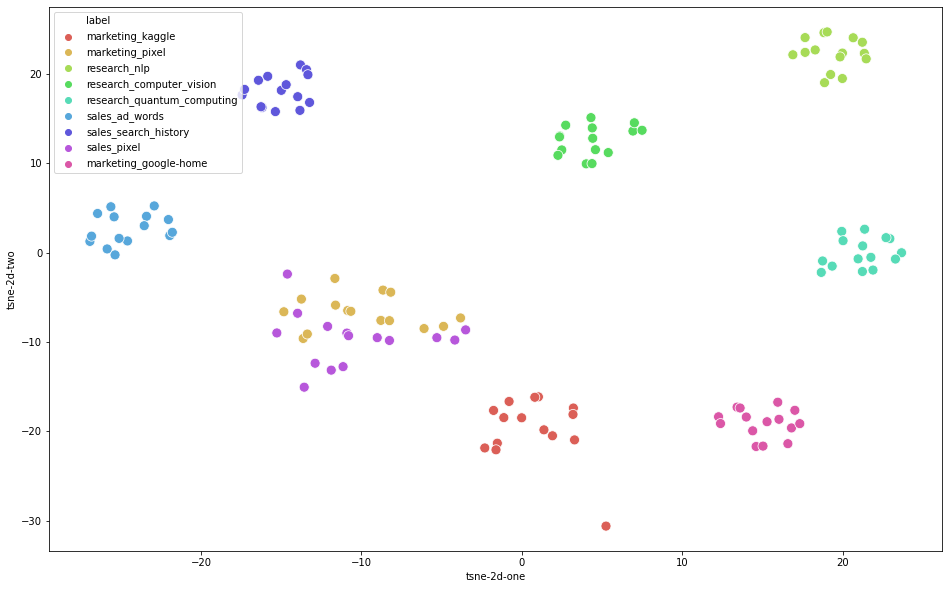

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# fig, ax = plt.subplots(figsize=(12,9))
# ax.scatter(tsne_results[0:18, 0], tsne_results[0:18, 1])
# plt.show()

df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['label'] = X['label']

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 9),
    data=df_subset,
    legend="full",
    alpha=1,
    s=100
)

## Modelling

In [17]:
# Data Prepraration
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

y = X['label']
X = X.drop(columns=['label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [18]:
set(X_train.index).intersection(set(X_test.index))

set()

So an empty intersection set of both sets proves that there is no observation common in train and test data

In [19]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [20]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [21]:
# Building Neural network
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = Sequential()
model.add(Dense(64, input_shape=(512,)))
model.add(Dense(100))
model.add(Dense(1000))
model.add(Dense(100))
model.add(Dense(len(set(y_train))))
model.add(Activation('softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
_________________________________________________________________
activation (Activation)      (None, 9)                 0         
Total params: 241,341
Trainable params: 241,341
Non-trainable params: 0
__________________________________________________

In [23]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

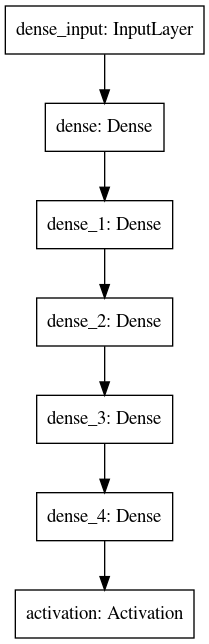

In [24]:
from tensorflow import keras
keras.utils.plot_model(model)

In [25]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
4/4 [==============================] - 0s 57ms/step - loss: 2.1128 - sparse_categorical_accuracy: 0.3056 - val_loss: 1.8226 - val_sparse_categorical_accuracy: 0.6296
Epoch 2/10
4/4 [==============================] - 0s 14ms/step - loss: 1.5878 - sparse_categorical_accuracy: 0.8519 - val_loss: 1.2505 - val_sparse_categorical_accuracy: 0.8519
Epoch 3/10
4/4 [==============================] - 0s 14ms/step - loss: 0.9444 - sparse_categorical_accuracy: 0.8704 - val_loss: 0.6432 - val_sparse_categorical_accuracy: 0.9630
Epoch 4/10
4/4 [==============================] - 0s 14ms/step - loss: 0.4064 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.1847 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 0s 14ms/step - loss: 0.1140 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0389 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 14ms/step - loss: 0.0369 - sparse_categorical_accuracy: 1.0000

In [26]:
#%tensorboard --logdir logs/fit

In [27]:
# gcloud compute ssh python-nlp-document-finder --project nlp-document-finder --zone us-west1-b -- -L 2222:localhost:6007 

### Prediction 

In [28]:
y_proba = model.predict(X_test)

In [29]:
y_pred = y_proba.argmax(axis=1)

In [30]:
y_proba

array([[2.80406852e-07, 1.33579235e-07, 1.59304591e-06, 2.04307275e-04,
        3.34333890e-05, 9.99760091e-01, 8.41805861e-11, 5.08075915e-10,
        2.81745770e-07],
       [9.49816751e-07, 9.88442771e-05, 1.66005395e-06, 9.99833107e-01,
        3.98891207e-05, 1.90808551e-05, 9.88801315e-12, 2.10876608e-10,
        6.48792957e-06],
       [9.20430510e-10, 2.64882587e-08, 5.42065892e-15, 7.64211563e-06,
        9.99822080e-01, 6.71790121e-06, 1.72646814e-10, 3.41126161e-16,
        1.63537334e-04],
       [3.34346844e-08, 1.42842723e-07, 1.79701885e-07, 3.39833525e-04,
        1.82141157e-04, 9.99472439e-01, 9.84025195e-10, 3.97720346e-09,
        5.27328439e-06],
       [9.99951124e-01, 3.72297072e-05, 1.16709998e-05, 1.62462210e-09,
        9.07011532e-12, 6.09284932e-12, 4.34748591e-11, 7.80706229e-13,
        4.79829243e-09],
       [4.52515138e-07, 2.84413196e-04, 6.53839720e-07, 9.99630570e-01,
        6.24336899e-05, 6.56001112e-06, 1.34752027e-11, 1.14552992e-10,
        1.4

In [31]:
le.classes_

array(['marketing_google-home', 'marketing_kaggle', 'marketing_pixel',
       'research_computer_vision', 'research_nlp',
       'research_quantum_computing', 'sales_ad_words', 'sales_pixel',
       'sales_search_history'], dtype=object)

In [32]:
rows[X_test.index[2]]

'give me nlp research document'

In [33]:
from operator import itemgetter
final_results = pd.DataFrame(data = list(itemgetter(*list(X_test.index))(rows)), index=X_test.index, columns=['inputs'])  

In [34]:
final_results['predictions'] = le.inverse_transform(y_pred)
final_results['true'] = le.inverse_transform(y_test)

In [35]:
final_results

,inputs,predictions,true
60,give me quantum computing research report,research_quantum_computing,research_quantum_computing
55,give me computer vision research file,research_computer_vision,research_computer_vision
35,give me nlp research document,research_nlp,research_nlp
68,display quantum computing research document,research_quantum_computing,research_quantum_computing
133,display google home marketing file,marketing_google-home,marketing_google-home
56,open computer vision research file,research_computer_vision,research_computer_vision
102,show me search history sales file,sales_search_history,sales_search_history
126,open google home marketing document,marketing_google-home,marketing_google-home
128,display google home marketing document,marketing_google-home,marketing_google-home
63,display quantum computing research report,research_quantum_computing,research_quantum_computing


In [36]:
for index in final_results.index:
    for intent in data['intents']:
        if intent['label'] == final_results.loc[index, 'predictions']:
            final_results.loc[index, 'query_search'] = intent['responses']

In [37]:
final_results

,inputs,predictions,true,query_search
60,give me quantum computing research report,research_quantum_computing,research_quantum_computing,/home/jupyter/Google/research/quantum_computin...
55,give me computer vision research file,research_computer_vision,research_computer_vision,[/home/jupyter/Google/research/computer_vision...
35,give me nlp research document,research_nlp,research_nlp,[/home/jupyter/Google/research/nlp.pdf]
68,display quantum computing research document,research_quantum_computing,research_quantum_computing,[/home/jupyter/Google/research/quantum_computi...
133,display google home marketing file,marketing_google-home,marketing_google-home,[/home/jupyter/Google/marketing/google-home.pdf]
56,open computer vision research file,research_computer_vision,research_computer_vision,[/home/jupyter/Google/research/computer_vision...
102,show me search history sales file,sales_search_history,sales_search_history,[/home/jupyter/Google/sales/search_history.pdf]
126,open google home marketing document,marketing_google-home,marketing_google-home,[/home/jupyter/Google/marketing/google-home.pdf]
128,display google home marketing document,marketing_google-home,marketing_google-home,[/home/jupyter/Google/marketing/google-home.pdf]
63,display quantum computing research report,research_quantum_computing,research_quantum_computing,[/home/jupyter/Google/research/quantum_computi...


## User Input Test

In [38]:
le.classes_

array(['marketing_google-home', 'marketing_kaggle', 'marketing_pixel',
       'research_computer_vision', 'research_nlp',
       'research_quantum_computing', 'sales_ad_words', 'sales_pixel',
       'sales_search_history'], dtype=object)

#### Test1: Asking with document name and folder name

In [39]:
user_input = ["Hi open the sales google home document please"]

embedding = embed(user_input)
X_user = pd.DataFrame(data=embedding.numpy())

In [40]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)
print(f"label predicted: {le.inverse_transform(y_pred)}")
for intent in data['intents']:
    if intent['label'] == le.inverse_transform(y_pred):
        print(f"Query search: {intent['responses']}")

label predicted: ['marketing_google-home']
Query search: ['/home/jupyter/Google/marketing/google-home.pdf']


In [41]:
(y_proba)

array([[9.8694617e-01, 2.7572986e-04, 1.3331309e-05, 1.5397050e-06,
        9.1145148e-06, 1.3177395e-06, 7.9548499e-04, 6.4537353e-06,
        1.1950884e-02]], dtype=float32)

#### Result: The user made a mistake. google home document is in marketing folder

#### Test2: Asking with document name and folder name but _'can you get me'_ this is not used in training data so far 

In [42]:
user_input = ["Hi can you get me sales pixel document"]

embedding = embed(user_input)
X_user = pd.DataFrame(data=embedding.numpy())

In [43]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)
print(f"label predicted: {le.inverse_transform(y_pred)}")
for intent in data['intents']:
    if intent['label'] == le.inverse_transform(y_pred):
        print(f"Query search: {intent['responses']}")

label predicted: ['sales_pixel']
Query search: ['/home/jupyter/Google/sales/pixel.pdf']


In [44]:
y_proba

array([[5.6794941e-10, 4.1927478e-08, 8.8413681e-06, 1.4242262e-09,
        5.8721691e-13, 1.2538218e-10, 2.0323001e-05, 9.9997079e-01,
        2.2762295e-08]], dtype=float32)

#### Result: The user asked for correct document from correct folder and model answer is correct.

#### Test3: Asking with document name but no folder name

In [45]:
user_input = ["Hi can you get me pixel document"]

embedding = embed(user_input)
X_user = pd.DataFrame(data=embedding.numpy())

In [46]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)
print(f"label predicted: {le.inverse_transform(y_pred)}")
for intent in data['intents']:
    if intent['label'] == le.inverse_transform(y_pred):
        print(f"Query search: {intent['responses']}")

label predicted: ['sales_pixel']
Query search: ['/home/jupyter/Google/sales/pixel.pdf']


#### Result: The user asked for correct document but did not specify and folder. Model gave just one correct result

In [47]:
# Lets y_proba

y_proba

array([[2.2117826e-08, 3.2689539e-07, 2.2564263e-03, 7.7915394e-07,
        5.2271815e-11, 5.4916999e-08, 1.4477998e-06, 9.9774098e-01,
        1.8831113e-08]], dtype=float32)

So here is one room for improvement. The model should also give high probability to second element of the above list sonce that corresponds to 'marketing_pixel' <br>
May be we can add few more such statements in training data itself.

#### Test4: Asking document created on a date

In [48]:
user_input = ["Please open kaggle marketing document created on 15 July"]

In [49]:
query_date = {}
for idx, row in enumerate(user_input):
    date_occurences = [(ent.text.strip(), ent.label_) for ent in sp_lg(row).ents if ent.label_ == 'DATE']
    query_date[row] = []
    
    for date in date_occurences:
        try:
            date_token = re.split('\s+|/|-|:',date[0])
            day, month, year = decode_date(date_token)
            query_date[row].append((day, month, year))
            row = row.replace(date[0], "", 1)
            user_input[idx] = row
        except:
            pass

In [50]:
embedding = embed(user_input)
X_user = pd.DataFrame(data=embedding.numpy())

In [51]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)
print(f"label predicted: {le.inverse_transform(y_pred)}")
for intent in data['intents']:
    if intent['label'] == le.inverse_transform(y_pred):
        print(f"Query search: {intent['responses']}")

label predicted: ['marketing_kaggle']
Query search: ['/home/jupyter/Google/marketing/kaggle.pdf']


In [52]:
# Lets y_proba

y_proba

array([[1.6556870e-03, 9.9826717e-01, 2.1857006e-05, 4.4980879e-05,
        2.9411940e-06, 3.2890762e-07, 1.0251360e-06, 4.6683152e-10,
        5.9961344e-06]], dtype=float32)

In [53]:
query_date

{'Please open kaggle marketing document created on 15 July': [(15, 7, 2020)]}

#### Test5: Asking document created on a date

In [54]:
user_input = ["Please open computer vision document created on 1/6/2019", "Please open computer vision document created on 1-6-2019", 
              "Give me google home document from 14/07", "Give me google home document from 14-07", "Give me google home document made 14 Jan", "Give me nlp document made on March 12"]

In [55]:
query_date = {}
for idx, row in enumerate(user_input):
    date_occurences = [(ent.text.strip(), ent.label_) for ent in sp_lg(row).ents if ent.label_ == 'DATE']
    query_date[row] = []
    for date in date_occurences:
        try:
            date_token = re.split('\s+|/|-|:',date[0])
            day, month, year = decode_date(date_token)
            query_date[row].append((day, month, year))
            row = row.replace(date[0], "", 1)
            user_input[idx] = row
        except:
            pass

In [56]:
embedding = embed(user_input)
X_user = pd.DataFrame(data=embedding.numpy())

In [57]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)

In [58]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)
print(f"label predicted: {le.inverse_transform(y_pred)}")
for pred in y_pred:
    for intent in data['intents']:
        if intent['label'] == le.inverse_transform(pred.reshape(1,)):
            print(f"Query search: {intent['responses']}")

label predicted: ['research_computer_vision' 'research_computer_vision'
 'marketing_google-home' 'marketing_google-home' 'marketing_google-home'
 'research_nlp']
Query search: ['/home/jupyter/Google/research/computer_vision.pdf']
Query search: ['/home/jupyter/Google/research/computer_vision.pdf']
Query search: ['/home/jupyter/Google/marketing/google-home.pdf']
Query search: ['/home/jupyter/Google/marketing/google-home.pdf']
Query search: ['/home/jupyter/Google/marketing/google-home.pdf']
Query search: ['/home/jupyter/Google/research/nlp.pdf']


In [59]:
# Lets y_proba
y_proba

array([[5.33545623e-04, 9.30739418e-02, 3.68167227e-03, 9.02084649e-01,
        8.97871214e-05, 3.11691430e-04, 7.62596414e-07, 1.08800286e-05,
        2.13025589e-04],
       [1.10946756e-04, 3.36272679e-02, 7.66430690e-04, 9.64738846e-01,
        1.20528879e-04, 2.76320177e-04, 6.41727866e-07, 1.00481202e-05,
        3.48963164e-04],
       [9.99800861e-01, 9.06539935e-06, 1.87730271e-04, 2.17945239e-06,
        2.45132394e-08, 1.07160346e-07, 2.18714366e-10, 2.12686271e-10,
        1.10025752e-07],
       [9.99950886e-01, 1.70502972e-05, 2.47012340e-05, 5.17395301e-06,
        3.21186207e-07, 4.99713160e-08, 4.70013528e-10, 8.68075611e-11,
        1.75576156e-06],
       [9.99918222e-01, 1.12441239e-05, 6.86649946e-05, 1.36227413e-06,
        2.90491560e-08, 2.44085712e-08, 1.70788272e-10, 1.07648057e-10,
        5.12550571e-07],
       [2.08953367e-07, 7.90273862e-06, 2.76500264e-11, 6.99014636e-05,
        9.89790261e-01, 1.11322777e-04, 1.95846155e-06, 5.19800487e-11,
        1.0

In [60]:
query_date

{'Please open computer vision document created on 1/6/2019': [],
 'Please open computer vision document created on 1-6-2019': [(1, 6, 2019)],
 'Give me google home document from 14/07': [],
 'Give me google home document from 14-07': [(14, 7, 2020)],
 'Give me google home document made 14 Jan': [(14, 1, 2020)],
 'Give me nlp document made on March 12': [(12, 3, 2020)]}